In [1]:
import tensorflow as tf
import numpy as np
from util import *
import os
import matplotlib.pyplot as plt
from tensorflow.python.ops import control_flow_ops
from losses import *
from flags_and_variables import *
from encode_boxes import *
from fcos import *

In [2]:
pyramid_dict = get_fpn_output(inputs,is_training=False,is_trainable=False)
centerness_output,classes_output,boxes_output = get_network_output(feature_layer_list,pyramid_dict,feature_size)
centerness_output = tf.concat(centerness_output,axis=1)
classes_output = tf.concat(classes_output,axis=1)
boxes_output = tf.concat(boxes_output,axis=1)

###testing part
centerness_pred = tf.sigmoid(centerness_output)
classes_pred = tf.sigmoid(classes_output)
localization_pred = boxes_output

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.


In [4]:
 _scores,_classes,_boxes = predict_outputs(centerness_pred,classes_pred,localization_pred,feature_size)
annotation = get_path_and_annotation('/media/xinje/New Volume/VOC07&12/VOC2007/test/test_2007.txt')
train_iter = read_data(annotation,1,input_shape=(800,1024),is_random=False,is_crop=False)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /media/xinje/New Volume/fcos/resnet_v2_50_giou/FCOS--1250
Restore from the checkpoint /media/xinje/New Volume/fcos/resnet_v2_50_giou/FCOS--1250


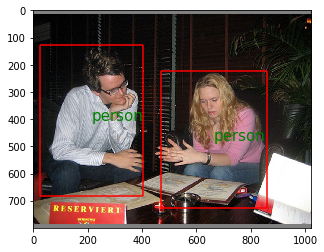

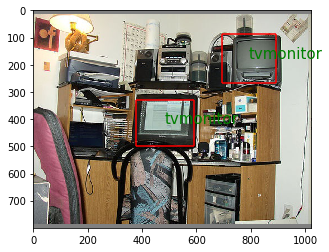

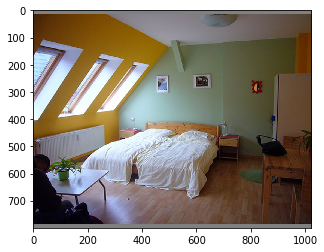

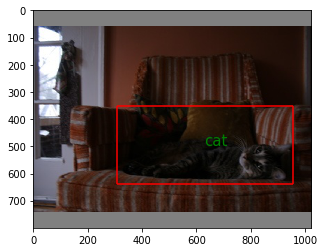

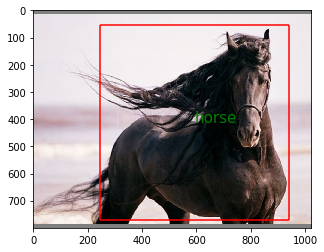

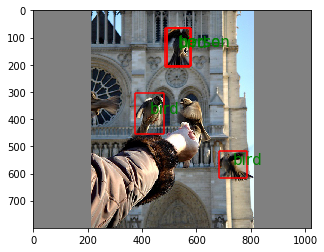

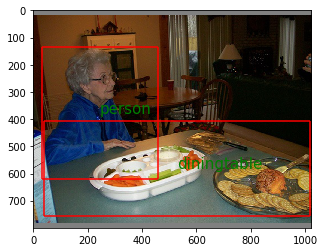

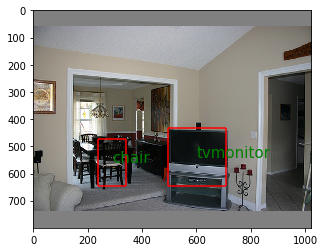

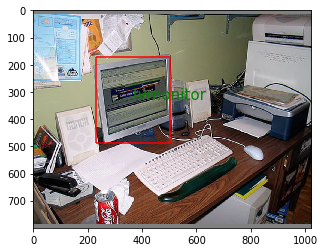

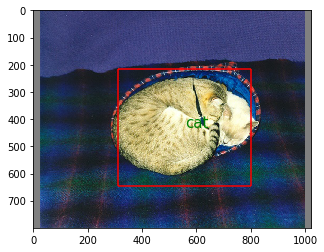

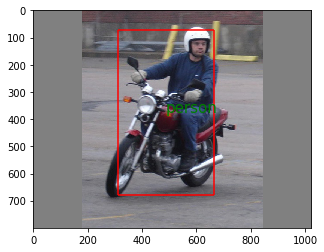

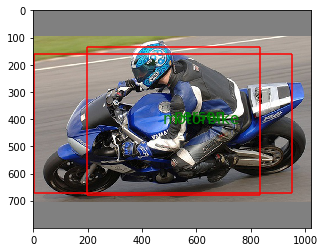

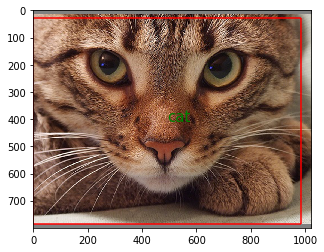

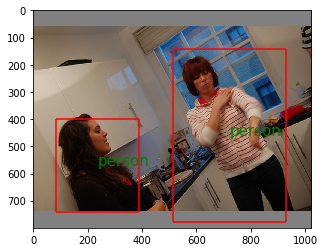

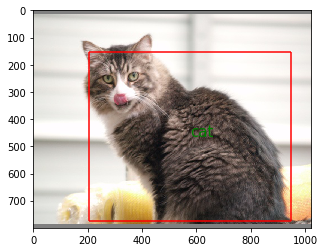

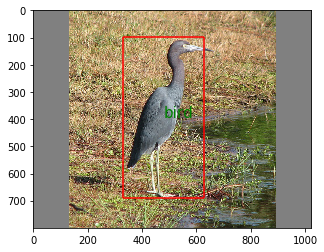

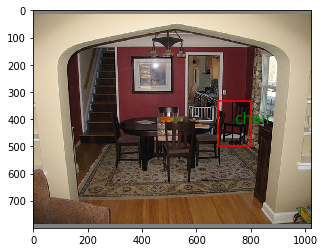

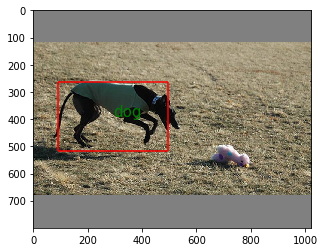

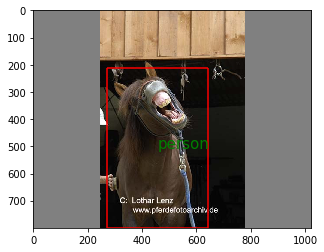

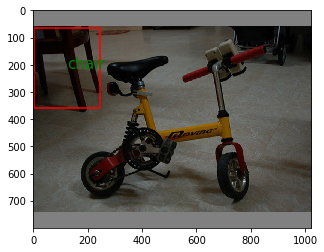

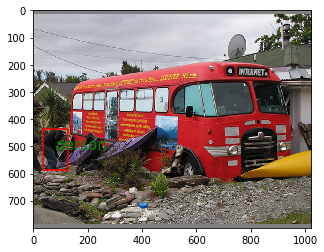

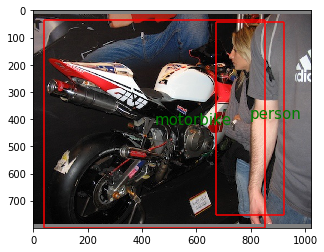

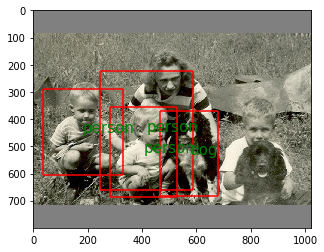

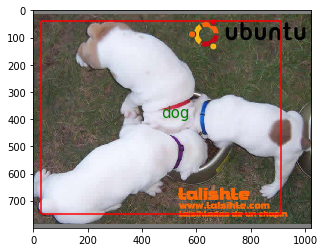

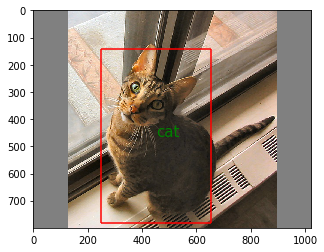

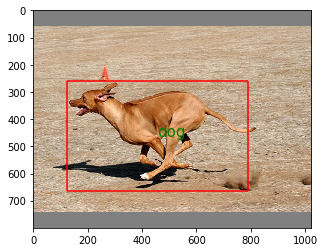

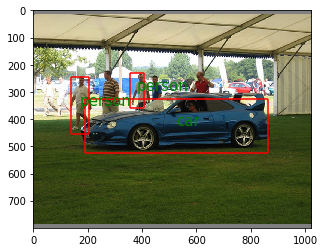

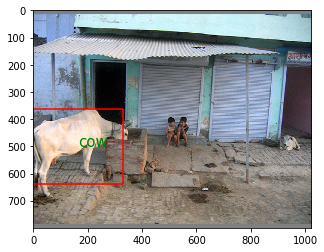

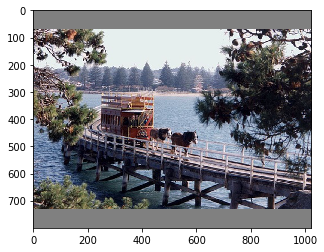

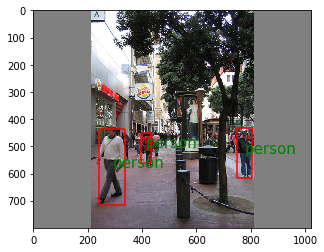

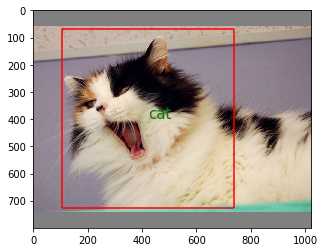

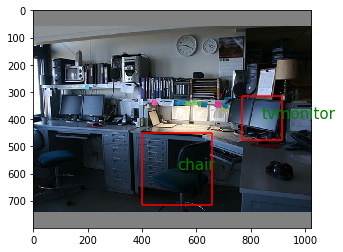

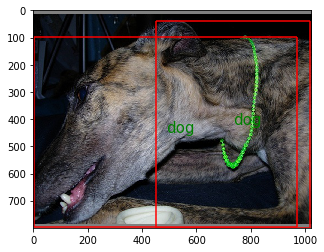

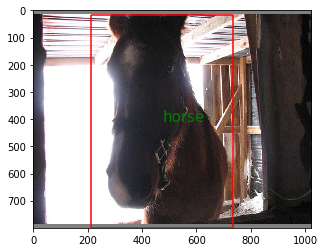

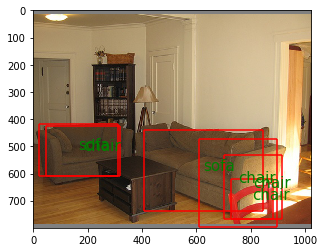

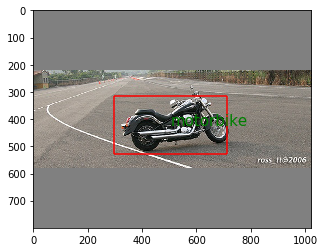

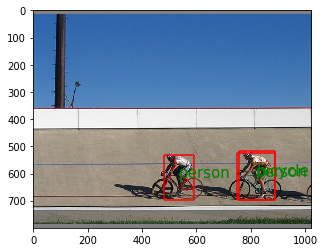

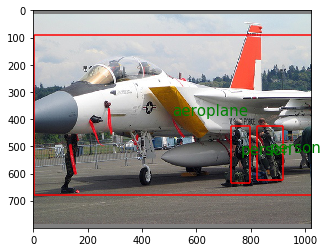

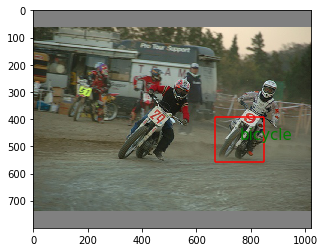

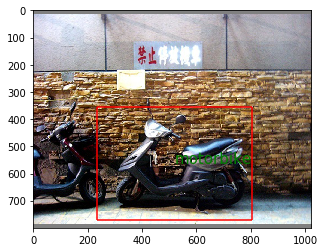

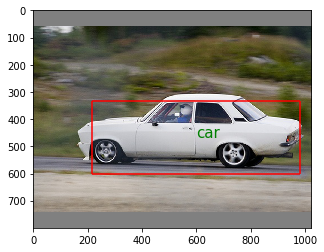

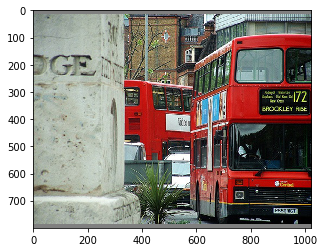

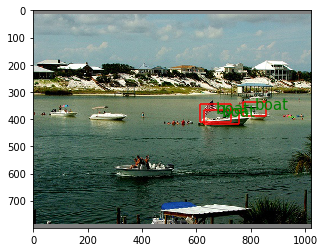

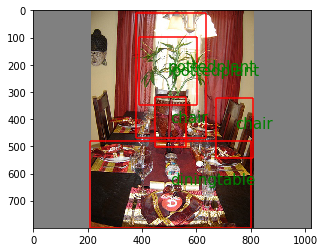

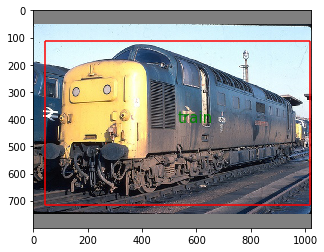

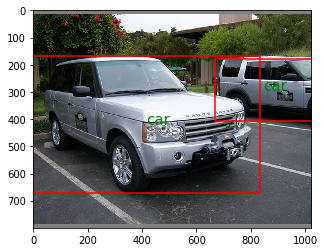

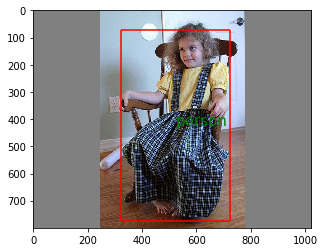

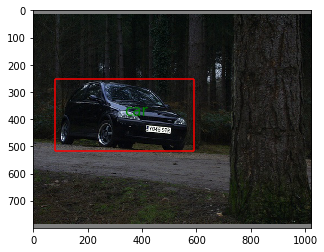

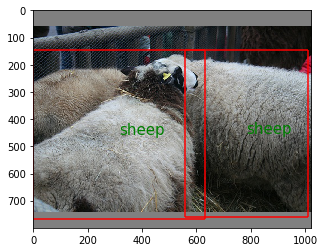

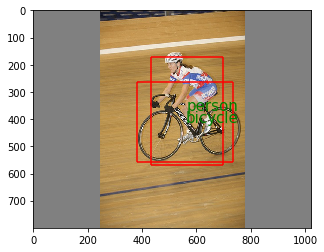

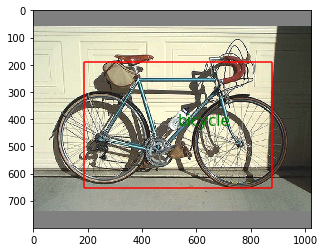

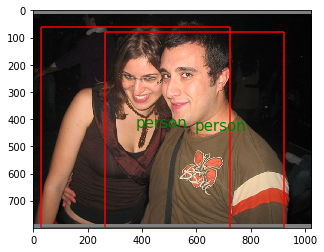

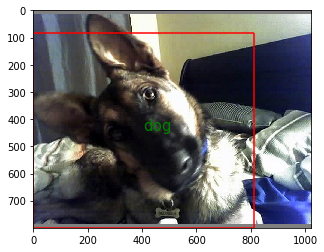

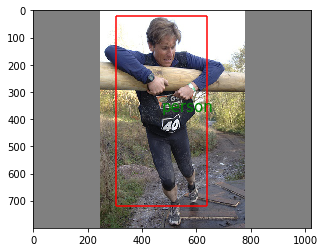

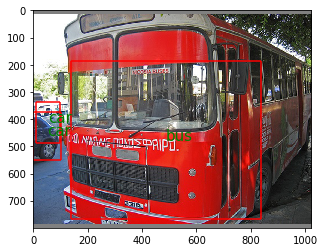

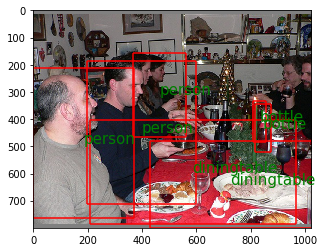

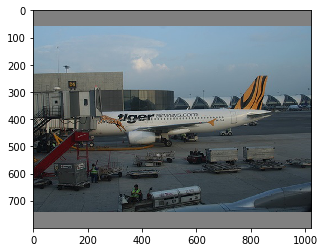

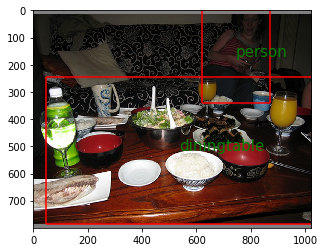

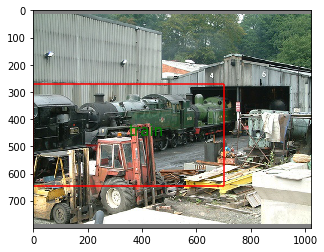

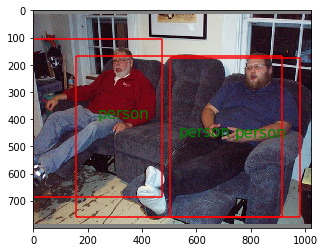

In [5]:
with tf.Session() as sess:
    train_writer = tf.summary.FileWriter(FLAGS.log_dir,sess.graph)
    var_list = [var for var in tf.global_variables() if ("Adam" and 'AccumGrad') not in var.name]
    saver = tf.train.Saver(var_list=var_list, max_to_keep=10)
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)
    if ckpt:
        saver.restore(sess,ckpt)
        print('Restore from the checkpoint {0}'.format(ckpt))
    else:
        print('No checkpoints found')
    for j in range(60):
        image_batch,annotation_batch,cls_batch = next(train_iter)
        [temp_scores_pred_list,temp_classes_pred_list,temp_localization_pred_list] = sess.run([  _scores,_classes,_boxes],feed_dict={inputs:image_batch})
        ymin,xmin,ymax,xmax=np.split(temp_localization_pred_list,axis=1,indices_or_sections =4)
        ymax[ymax>FLAGS.image_height]=FLAGS.image_height
        xmax[xmax>FLAGS.image_width]=FLAGS.image_width
        ymin[ymin<0]=0
        xmin[xmin<0]=0
        plt.hlines(ymin,xmin,xmax,'r')
        plt.hlines(ymax,xmin,xmax,'r')
        plt.vlines(xmin,ymin,ymax,'r')
        plt.vlines(xmax,ymin,ymax,'r')
        for i in range(temp_classes_pred_list.shape[0]):
            position = ((ymin[i]+ymax[i])/2,(xmin[i]+xmax[i])/2)
            plt.text(position[1],position[0],corresponding_dict[temp_classes_pred_list[i]],color='g',size = 15)
        plt.imshow(image_batch[0])
        plt.show()

In [6]:
annotation = get_path_and_annotation('/media/xinje/New Volume/VOC07&12/VOC2007/test/test_2007.txt')
train_iter = read_data(annotation,FLAGS.batch_size,input_shape=(800,1024),is_random=False,is_crop=False)

In [7]:
# def predict_outputs(centerness_pred,classes_pred,localization_pred,feature_size):
#     scores_pred_list = []
#     classes_pred_list = []
#     localization_pred_list = []
#     m_w = np.array([-1,64,128,256,512,np.inf])/FLAGS.image_width
#     m_h = np.array([-1,64,128,256,512,np.inf])/FLAGS.image_height
#     for i in range(5):
#         #change top,bottom,left,right to ymin,xmin,ymax,xmax
#     # feature_size=[(100,128),(50,64),(25,32),(13,16),(7,8)]
#     # stride=[8,16,32,64,128]
#         m_w_min =m_w[i]
#         m_w_max =m_w[i+1]
#         m_h_min =m_h[i]
#         m_h_max =m_h[i+1]
#         #ensure the predicted boxes max(top,bottom,left,right) is in the domain(m_h_min,m_w_max)
#             #the mim(top,bottom,left,right) is bigger than 1 pixel
#         localization_mask = tf.expand_dims(tf.logical_and((tf.reduce_min(localization_pred[i],axis=-1)>m_h_min),(tf.reduce_max(localization_pred[i],axis=-1)<=m_w_max)),axis=-1)
#         localization_mask = tf.cast(localization_mask,tf.float32) * tf.cast(tf.expand_dims((tf.reduce_min(localization_pred[i],axis=-1)>0.001),axis=-1),tf.float32)
#         localization_pred[i] = localization_pred[i] * localization_mask
#         centerness_pred[i]  = centerness_pred[i] *localization_mask
#         classes_pred[i] = classes_pred[i] * localization_mask
#         offset = np.math.floor(stride[i]/2)
#         y_center_mapping = np.array([(j*stride[i]+offset) for j in range(feature_size[i][0])])/FLAGS.image_height
#         x_center_mapping = np.array([(j*stride[i]+offset) for j in range(feature_size[i][1])])/FLAGS.image_width
# #         y_center_mapping = np.expand_dims(np.tile(np.expand_dims(y_center_mapping,axis=-1),[1,feature_size[i][1]]),axis=-1)
# #         x_center_mapping = np.expand_dims(np.tile(np.expand_dims(x_center_mapping,axis=0),[feature_size[i][0],1]),axis=-1)
# #         center = np.concatenate([y_center_mapping,x_center_mapping],axis=-1).reshape(1,(feature_size[i][0]*feature_size[i][1]),2)
#         ymin = tf.expand_dims((y_center_mapping-localization_pred[i][...,0]) * FLAGS.image_height,axis=-1)
#         ymax = tf.expand_dims((y_center_mapping+localization_pred[i][...,1]) * FLAGS.image_height,axis=-1)
#         xmin = tf.expand_dims((x_center_mapping-localization_pred[i][...,2]) * FLAGS.image_width,axis=-1)
#         xmax = tf.expand_dims((x_center_mapping+localization_pred[i][...,3]) * FLAGS.image_width,axis=-1)
#         localization_pred[i] = tf.concat([ymin,xmin,ymax,xmax],axis=-1)

#         localization_pred_list.append(tf.reshape(localization_pred[i],[-1,4]))
#         classes_pred_list.append(tf.reshape(classes_pred[i],[-1,FLAGS.num_class]))
#         scores_pred_list.append(tf.reshape((centerness_pred[i] * classes_pred[i]),[-1,FLAGS.num_class]))
#     #     scores_pred_list.append(tf.reshape((classes_pred),[-1,FLAGS.num_class]))

#     localization_pred_list = tf.concat(localization_pred_list,axis=0)  
#     classes_pred_list = tf.concat(classes_pred_list,axis=0)  
#     scores_pred_list = tf.concat(scores_pred_list,axis=0)  
    
#     mask = scores_pred_list > 0.5
#     _boxes = []
#     _classes = []
#     _scores = []
#     for c in range(FLAGS.num_class):
#     ##nms
#         _localization_pred = tf.boolean_mask(localization_pred_list,mask[:,c])
#         _scores_pred = tf.boolean_mask(scores_pred_list[:,c],mask[:,c])
#         nms_index = tf.image.non_max_suppression(
#             _localization_pred, _scores_pred, 10, iou_threshold = 0.5)
#         _boxes.append(tf.gather(_localization_pred, nms_index))
#         _scores.append(tf.gather(_scores_pred,nms_index))
#         _classes.append(tf.ones_like(_scores_pred, 'int32') * c)
#     _boxes = tf.concat(_boxes,axis=0)
#     _scores = tf.concat(_scores,axis=0)
#     _classes = tf.concat(_classes,axis=0)
#     return  scores_pred_list,classes_pred_list,localization_pred_list